In [187]:
import glob
import os
import itertools
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs import FingerprintSimilarity
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### MFP_matrix

`AllChem.GetMorganFingerprintAsBitVect(mol, 2`) is used to generate the Morgan fingerprint for each molecule in `mol_list`.
_The Morgan fingerprint_ is a type of circular fingerprint that represents the molecular structure of a compound. 
The 2 in the function call specifies the radius of the circular fingerprint. This means that the fingerprint will capture structural information up to **two bonds** away from each atom.

`itertools.product(fp, repeat=2)` generates all possible pairs of fingerprints from the fp. 
Then `FingerprintSimilarity(x, y)` calculetes similiraty score between x and y (all combinations generated by itertools.product from the list `fp`) and store them in the `mfps` list.

Finally, we convert the `mfps` list into a Numpy array that is reshaped into a a square matrix. 


In [188]:

def MFP_matrix(mol_list):
    fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in mol_list] #  list fp containing Morgan fingerprints for all molecules in mol_list.
    mfps = list(FingerprintSimilarity(x, y) for x, y in itertools.product(fp, repeat=2))  
    return fp, np.array(mfps).reshape(len(fp), len(fp))

/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


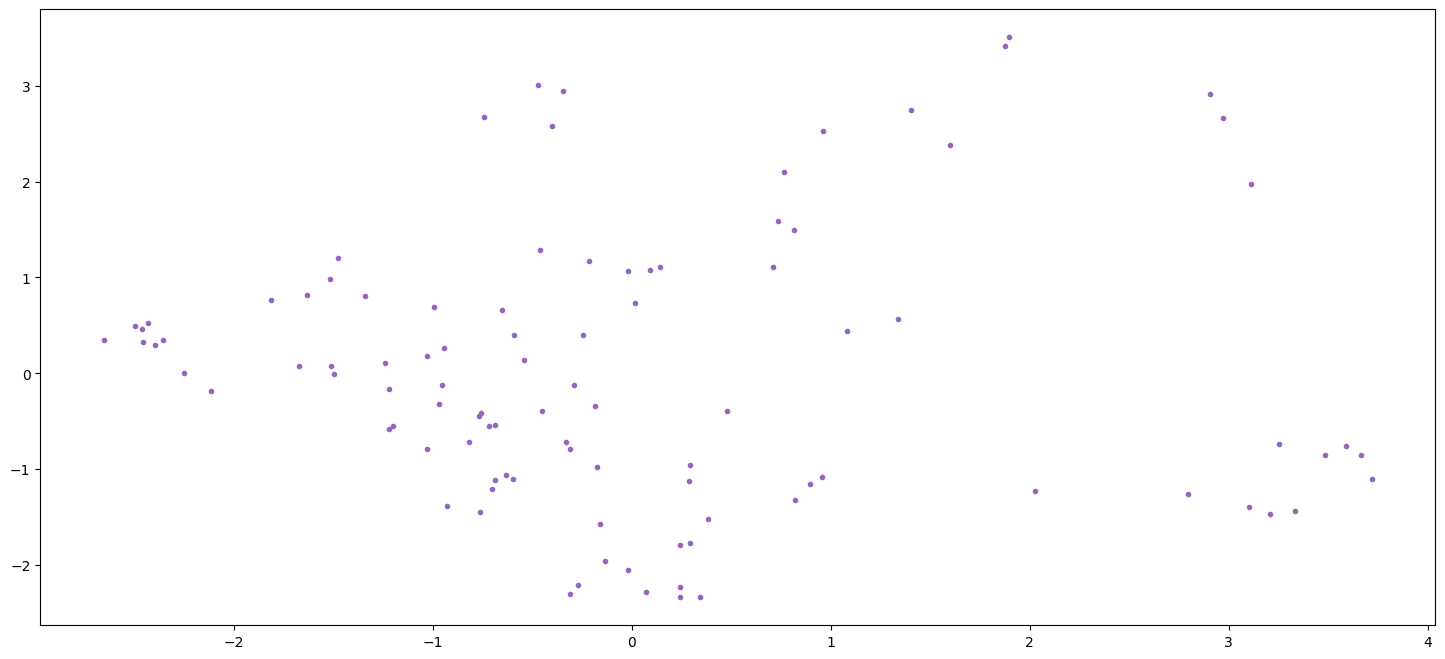

In [189]:
target_data = {}
target_labels = []


sdf = ['KNC']
sdd = glob.glob('{}'.format(os.getcwd())+f'/{sdf}*.sdf')
sdf = sdd[0]
target = sdf.split('\\')[-1].split('_ligand')[0]
suppl = Chem.SDMolSupplier(sdf)
fp_list, fp_mat = MFP_matrix(suppl)
name_list = [mol.GetProp('_Name') for mol in suppl]
target_data[target] = {}
target_data[target]['fp_list'] = fp_list
target_data[target]['name_list'] = name_list
target_labels.extend([target] * len(suppl))

fps = [target_data[targ]['fp_list'] for targ in target_data.keys()]
flat_fps = np.array([fp for target in fps for fp in target])

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(flat_fps)

# Apply k-means clustering
num_clusters = 20  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(pca_coords)
cluster_labels = kmeans.labels_

fig = plt.figure(figsize=(18, 8))
X = [i[0] for i in pca_coords]  
Y = [i[1] for i in pca_coords]  
markers = ['.', 'x']
k = 0
for target in target_data.keys():  
    k += 1
    if k <= 8:
        m = markers[0]
    else:
        m = markers[1]
    indices = [i for i, target_label in enumerate(target_labels) if target_label == target]
    targ_x = [X[i] for i in indices]
    targ_y = [Y[i] for i in indices]
    cluster_label = cluster_labels[indices[0]]  
    color = cm.tab20(cluster_label)  #Color
    plt.scatter(targ_x, targ_y, label=target, marker=m, color=color)



In [195]:
import glob
import os
import itertools
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs import FingerprintSimilarity
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def MFP_matrix(mol_list):
    fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in mol_list]
    mfps = list(FingerprintSimilarity(x, y) for x, y in itertools.product(fp, repeat=2))
    return fp, np.array(mfps).reshape(len(fp), len(fp))

sdf = ['KNC']
sdd = glob.glob('{}'.format(os.getcwd())+f'/{sdf}*.sdf')
sdf = sdd[0]
target = sdf.split('\\')[-1].split('_ligand')[0]
suppl = Chem.SDMolSupplier(sdf)
fp_list, fp_mat = MFP_matrix(suppl)
name_list = [mol.GetProp('_Name') for mol in suppl]
target_data[target] = {}
target_data[target]['fp_list'] = fp_list
target_data[target]['name_list'] = name_list
target_labels.extend([target] * len(suppl))

fps = [target_data[targ]['fp_list'] for targ in target_data.keys()]
flat_fps = np.array([fp for target in fps for fp in target])

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(flat_fps)

# Apply k-means clustering
num_clusters = 20  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(pca_coords)
cluster_labels = kmeans.labels_

fig = plt.figure(figsize=(18, 8))
X = [i[0] for i in pca_coords]  
Y = [i[1] for i in pca_coords]  
markers = ['.', 'x']
k = 0
for target in target_data.keys():  
    k += 1
    if k <= 8:
        m = markers[0]
    else:
        m = markers[1]
    indices = [i for i, target_label in enumerate(target_labels) if target_label == target]

    if indices:
        targ_x = [X[i] for i in indices]
        targ_y = [Y[i] for i in indices]
        cluster_label = cluster_labels[indices[0]]  
        color = cm.tab20(cluster_label)  #Color
        plt.scatter(targ_x, targ_y, label=target, marker=m, color=color)

# Plot cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='black', s=150, label='Centroids')

plt.title('PCA with K-means Clustering')
plt.xlabel('PCA {}%'.format(round(pca.explained_variance_ratio_[0] * 100, 2)))
plt.ylabel('PCA {}%'.format(round(pca.explained_variance_ratio_[1] * 100, 2)))
plt.grid()
plt.show()

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='black', s=150, label='Centroids')

# Find the closest molecule to each centroid
f = open ('./20-centroids.txt', 'w')
for i, centroid in enumerate(centroids):

    cluster_label = i
    name = './cluster'+str(i)+'.txt'
    c = open (name, 'w')
    cluster_indices = [index for index, label in enumerate(cluster_labels) if label == cluster_label]
    cluster_mols = [target_data[target_labels[index]]['name_list'][0] for index in cluster_indices]
    for i in range(len(cluster_mols)):
        print(f"{cluster_mols[i]}", file=c)
    
    closest_mol_index = min(cluster_indices, key=lambda x: np.linalg.norm(pca_coords[x] - centroid))
    closest_mol_name = target_data[target_labels[closest_mol_index]]['name_list'][0]
    print(closest_mol_name, file=f)
    plt.text(centroid[0], centroid[1], closest_mol_name, color='red', fontsize=10)

plt.title('PCA with K-means Clustering')
plt.xlabel('PCA {}%'.format(round(pca.explained_variance_ratio_[0] * 100, 2)))
plt.ylabel('PCA {}%'.format(round(pca.explained_variance_ratio_[1] * 100, 2)))
plt.grid()
plt.show()

/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


IndexError: list index out of range

<Figure size 1800x800 with 0 Axes>

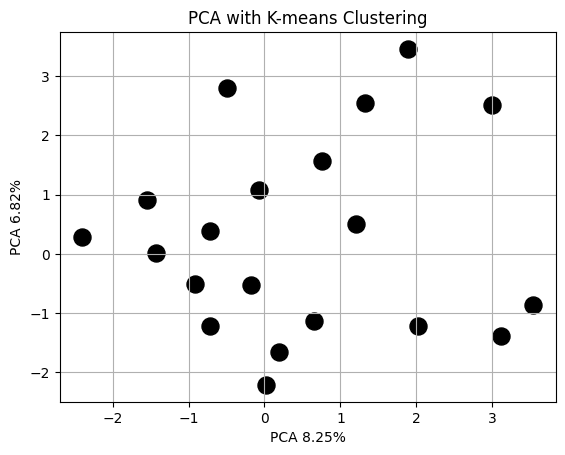

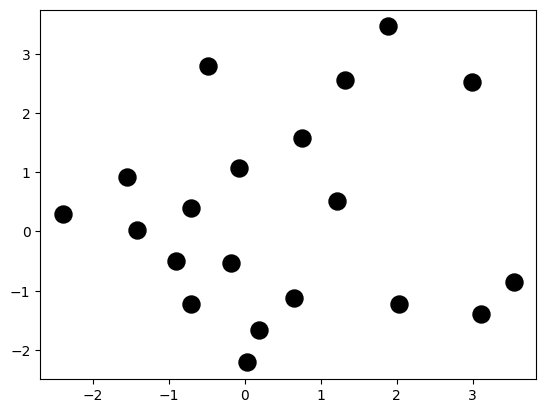

In [190]:
# Plot cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='black', s=150, label='Centroids')

plt.title('PCA with K-means Clustering')
plt.xlabel('PCA {}%'.format(round(pca.explained_variance_ratio_[0] * 100, 2)))
plt.ylabel('PCA {}%'.format(round(pca.explained_variance_ratio_[1] * 100, 2)))
plt.grid()
plt.show()

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='black', s=150, label='Centroids')

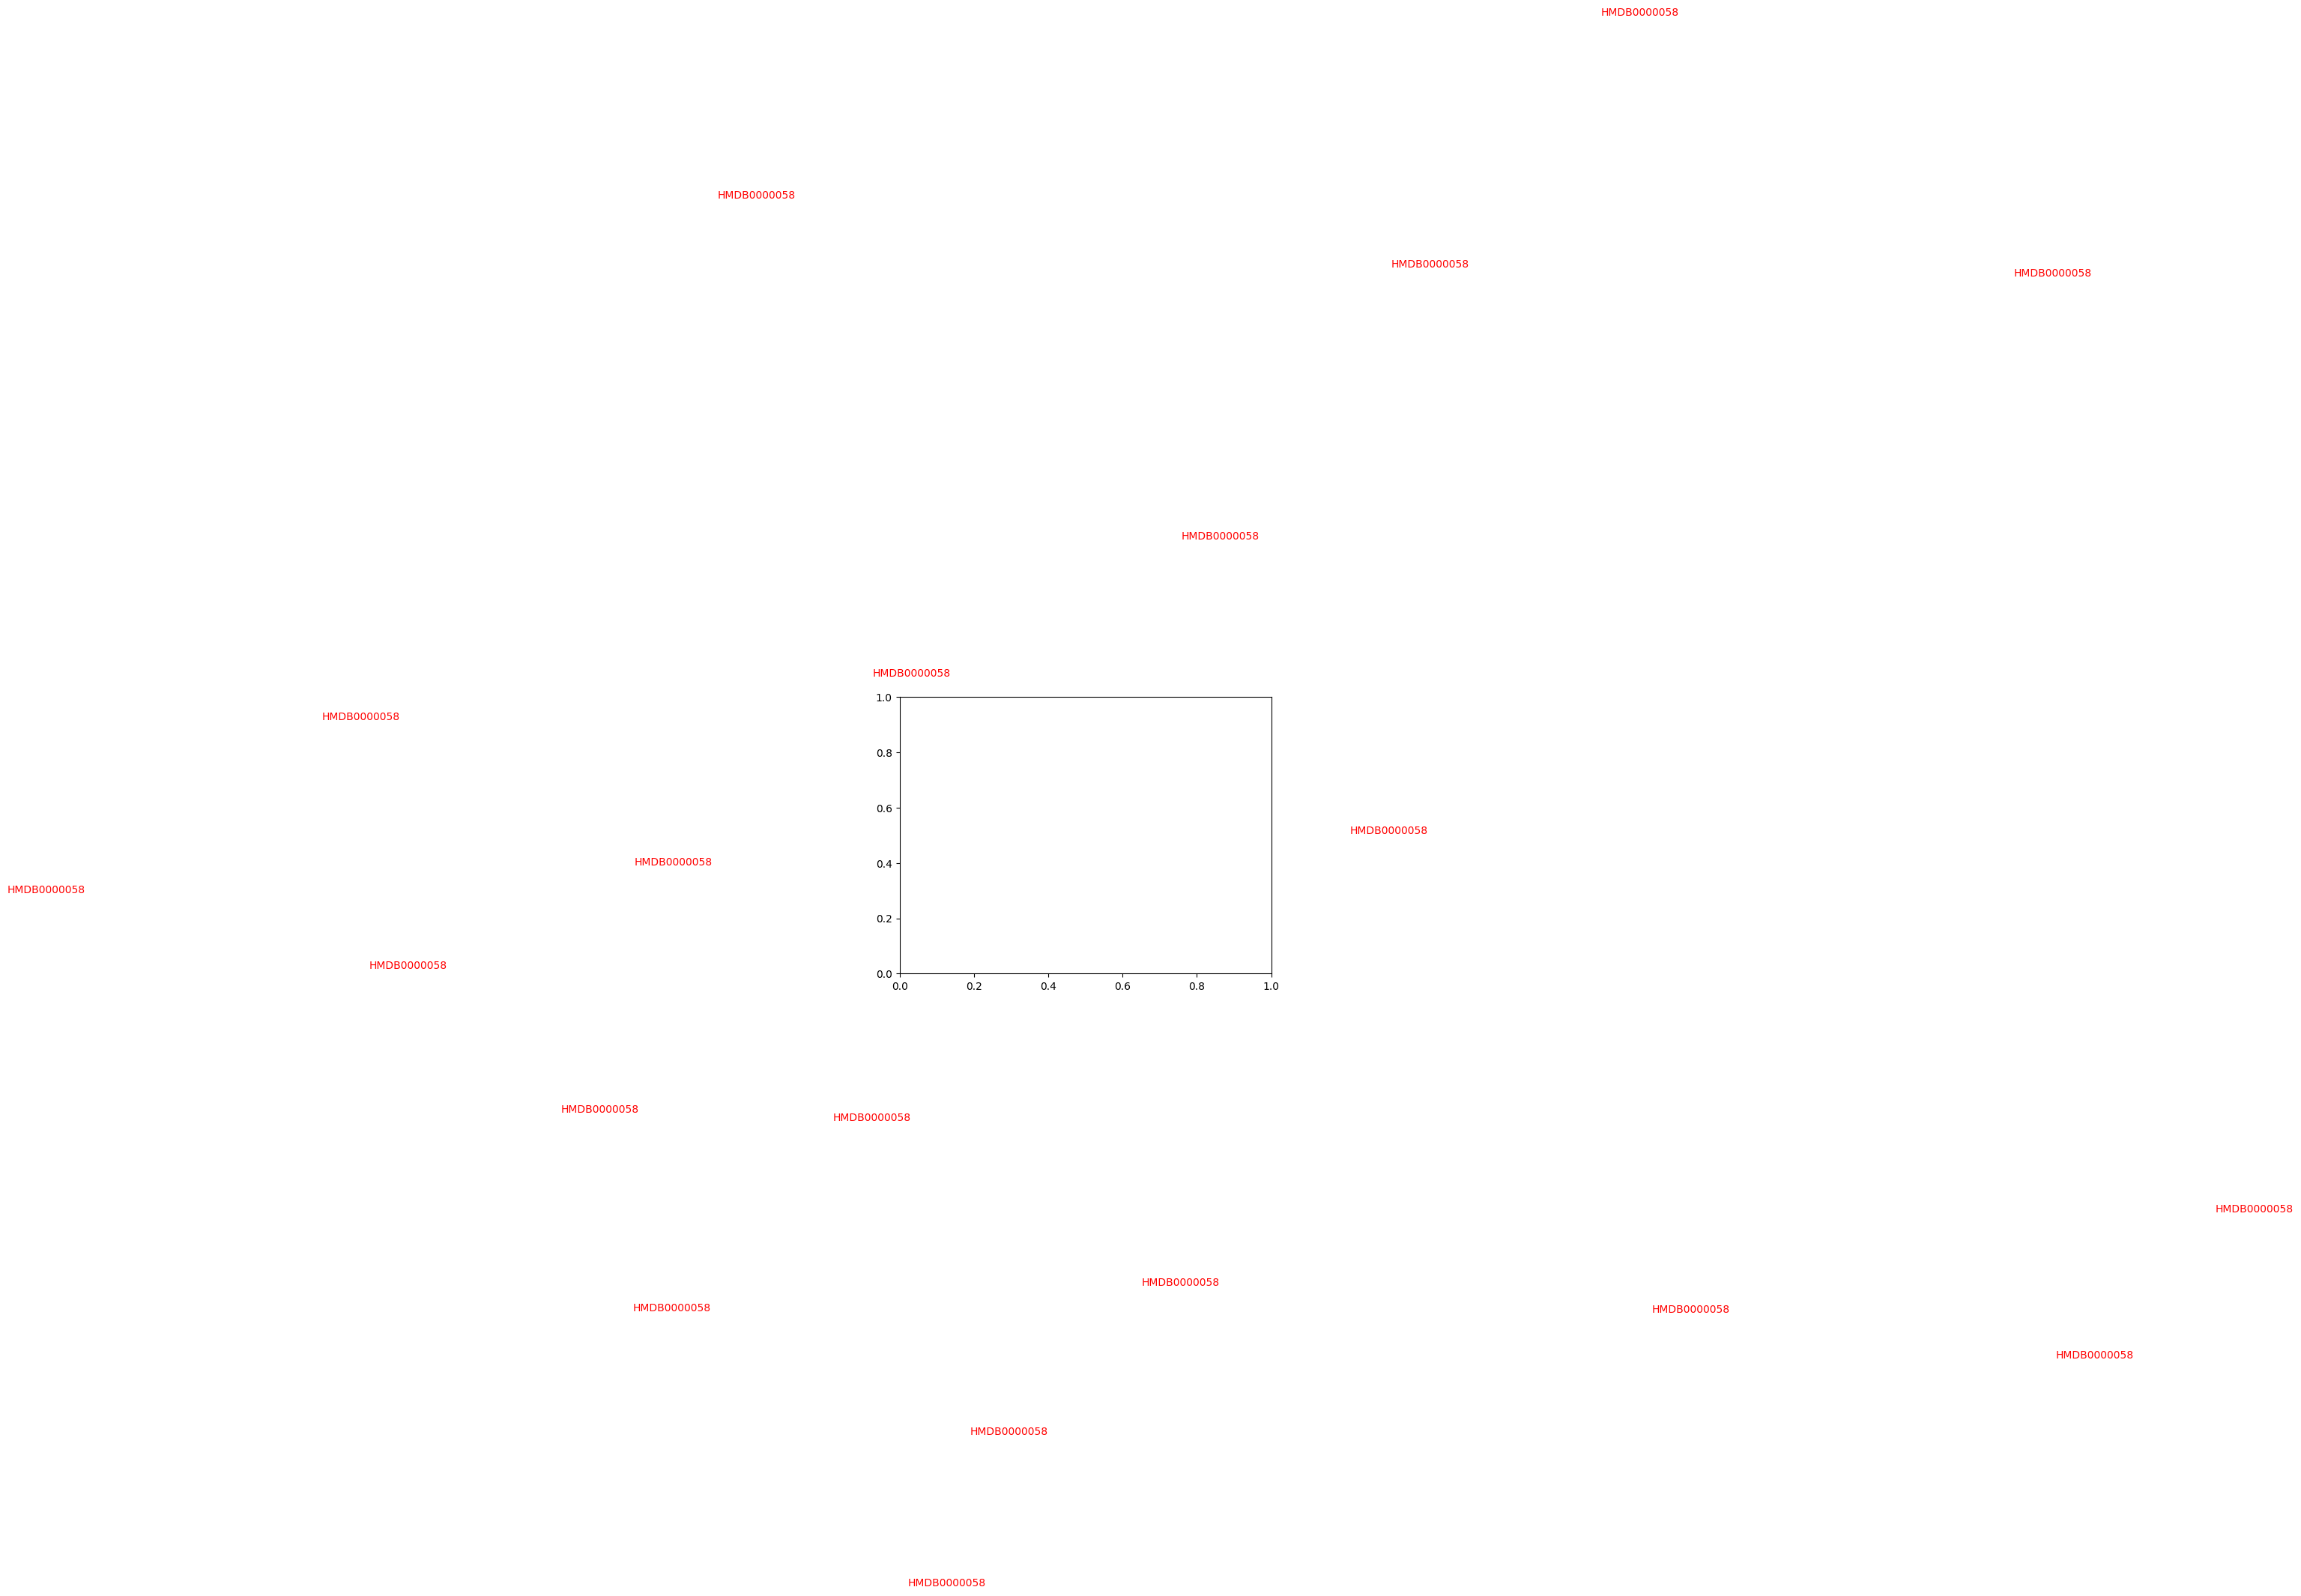

In [192]:
# Find the closest molecule to each centroid
f = open ('./20-centroids.txt', 'w')
for i, centroid in enumerate(centroids):

    cluster_label = i
    name = './cluster'+str(i)+'.txt'
    c = open (name, 'w')
    cluster_indices = [index for index, label in enumerate(cluster_labels) if label == cluster_label]
    cluster_mols = [target_data[target_labels[index]]['name_list'][0] for index in cluster_indices]
    for i in range(len(cluster_mols)):
        print(f"{cluster_mols[i]}", file=c)
    
    closest_mol_index = min(cluster_indices, key=lambda x: np.linalg.norm(pca_coords[x] - centroid))
    closest_mol_name = target_data[target_labels[closest_mol_index]]['name_list'][0]
    print(closest_mol_name, file=f)
    plt.text(centroid[0], centroid[1], closest_mol_name, color='red', fontsize=10)


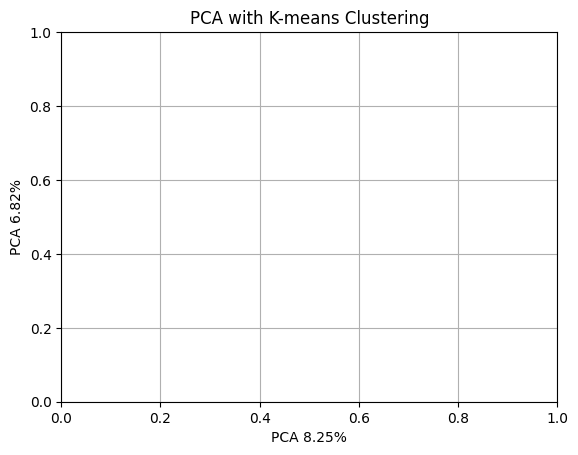

In [193]:
plt.title('PCA with K-means Clustering')
plt.xlabel('PCA {}%'.format(round(pca.explained_variance_ratio_[0] * 100, 2)))
plt.ylabel('PCA {}%'.format(round(pca.explained_variance_ratio_[1] * 100, 2)))
plt.grid()
plt.show()